### Libraries

In [185]:
import gc
import warnings

warnings.filterwarnings('ignore')
from importlib import reload
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
import dask
#import xrft
import ephem
import cmocean
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt

from cmocean import cm
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from matplotlib.colors import LogNorm, TwoSlopeNorm

In [187]:
import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.DEBUG,
    datefmt="%Y-%m-%d %H:%M:%S")

#logging.getLogger("matplotlib.font_manager").setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

In [193]:
#%reload_ext autoreload
%autoreload

#reload() solo funciona si el módulo ya fue cargado
import spectral_analysis
reload(spectral_analysis)
import spectral_analysis.filtering
reload(spectral_analysis.filtering)
from spectral_analysis.filtering import kxky, f_range
import spectral_analysis.tools.utils_thesis
reload(spectral_analysis.tools.utils_thesis)
#from spectral_analysis.tools.utils_thesis import igw_disp_rel, igw_bm_partition_k
import spectral_analysis.luigi_workflows.output
reload(spectral_analysis.luigi_workflows.output)

from spectral_analysis.common_vars.time_slices import idx_t
from spectral_analysis.common_vars.directories import DATA_FOLDER,LUIGI_OUT_FOLDER
from spectral_analysis.luigi_workflows.llc_region import LLCRegion
from spectral_analysis.common_vars.regions import lats4id, tzinfo_regions, ids_Cal, ids_Can, ids_Peru, ids_Ben

print(DATA_FOLDER)
print(LUIGI_OUT_FOLDER)

/media/antonio/DATA_SAVE/LLC4320/GDriveBackup/Tesis/data
/media/antonio/DATA_SAVE/LLC4320/Luigi


### Define functions

In [5]:
def kxky_(dx,dy,shape):
    Ny,Nx = shape
    logging.info("kxky -- Nx: {}, Ny: {}".format(Nx,Ny))
    Lx = Nx*dx
    Ly = Ny*dy
    logging.info("kxky -- Lx: {}, Ly: {}".format(Lx,Ly))
    delta_kx = 1/Lx
    delta_ky = 1/Ly
    N_kx = (Nx-1)/2
    N_ky = (Ny-1)/2
    Kx = delta_kx*da.arange(-N_kx,N_kx+1)
    Ky = delta_ky*da.arange(-N_ky,N_ky+1)
    return Kx,Ky


def f_range_(dt,Nt):
    T = Nt*dt
    logging.info("f_range -- Nt: {}, T: {}".format(Nt,T))
    delta_om = 1/T
    N_om = (Nt-1)/2
    return  delta_om*da.arange(-N_om,N_om+1)

In [6]:
## Units:
## kh,H: km
## f,Nbv: cph

def igw_disp_rel(kh, max_mode=10, f_coriolis=None, Nbv=0.8594, H=4.0, log=True):
    if log:
        print("N={0:.3f}, H={1:.3f} - mode {2}".format(Nbv, H, max_mode))
    kh = (2*np.pi)*kh 	# Transform to rad/km
    khnp_2 = (max_mode*np.pi/(kh*H))**2

    return da.sqrt( (Nbv**2 + ((f_coriolis**2)*khnp_2))/(1+khnp_2) )


def igw10_bm_partition_k(kh, fmax=1/12.0, **disp_kwargs):
    igw10 = igw_disp_rel(kh, max_mode=10, **disp_kwargs)
    logging.debug("igw10 shape: {}".format(igw10.shape))

    return da.fmin(igw10, fmax)


def create_igw10_cutoff(shape, dx=2.0, dy=2.0, dt=1.0, **partition_args):
    Nx,Ny,Nt = shape
    om_ = f_range_(dt,Nt)
    kx_,ky_ = kxky_(dx, dy, (Nx,Ny))
    kx,ky,om = da.meshgrid(kx_, ky_, om_)
    #logging.debug("spectral shape: {}, {}, {} --> {}, {}, {}", kx_.shape, ky_.shape, om_.shape, kx.shape, ky.shape, om.shape)

    kh_sq = da.square(kx)+da.square(ky)
    kh = da.sqrt(kh_sq)

    return igw10_bm_partition_k(kh, **partition_args), kx, ky, om


def create_filter_igw10(shape, order=50, **partition_args):
    cutoff_igw10, kx, ky, om = create_igw10_cutoff(shape,  **partition_args)
    logging.debug("cutoff_igw10 shape: {}".format(cutoff_igw10.shape))
    with np.errstate(over='ignore'):
        filter_mask_plt = 1/( 1 + ( da.square(om)/(cutoff_igw10**2) )**order )
        filter_mask = da.fft.ifftshift(filter_mask_plt)
        return filter_mask, kx, ky, om


In [7]:
# TODO: multiplicar por Hanning

def fft_3d(var_txy, inverse=False):
    _v_fft = var_txy
    dim = len(var_txy.shape)
    for ax in range(dim):
        rechunks = {x:'auto' for x in range(dim) }
        rechunks[ax] = -1
        _v_fft = _v_fft.rechunk(rechunks)
        _v_fft = da.fft.fft(_v_fft, axis=ax) if not inverse else da.fft.ifft(_v_fft, axis=ax)
    return _v_fft

#@dask.delayed(pure=True)
def filter_fft_butterworth_k_omega(var_txy, filter_mask, dx=2.0, dy=2.0, dt_h=1, t_axis=-1):
    logging.info("kx-ky-omega BW filter -- variable shape: {} -- type: {}".format(var_txy.shape, type(var_txy)))
    arr_delayed_kwargs = {"shape": var_txy.shape, "dtype": np.dtype('f')}
    
    logging.info("Calculating FFT... mask type: {}".format(type(filter_mask)))
    #var_fft = xrft.fft(var_txy)
    var_fft = fft_3d(var_txy)
    logging.info("Filtering...")
    var_lo = filter_mask*var_fft
    del filter_mask
    
    # Volvemos al espacio físico
    logging.info("Calculating inverse FFT and complement")
    #var_lo = xrft.ifft(var_lo)
    var_lo = fft_3d(var_lo, inverse=True)
    logging.info("Taking real part FFT: {}".format(type(var_lo)))
    var_lo = da.real(var_lo)   # Eliminamos la parte imaginaria, ya que es espuria
    
    return var_lo


In [8]:
import zoneinfo

## Calculates "real" date from simualtion hours, given a start date
startDt = datetime.datetime(2011,9,13,0,0,0,0,tzinfo=datetime.timezone.utc)

def simulationTime(hours):
    return startDt + datetime.timedelta(hours=hours)

def timeUtc(simHours):
    return ephem.Date(simulationTime(simHours))

## Init Dask cluster

In [198]:
#client = Client("tcp://127.0.0.1:9999")
client = Client()
client

2022-03-24 00:21:05 DEBUG    Using selector: EpollSelector
2022-03-24 00:21:05 DEBUG    Using selector: EpollSelector


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 40,Total memory: 62.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36779,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 40
Started: Just now,Total memory: 62.68 GiB
Comm: tcp://127.0.0.1:46263,Total threads: 5
Dashboard: http://127.0.0.1:44455/status,Memory: 7.84 GiB
Nanny: tcp://127.0.0.1:36347,


## Massage data: prepare base (0) checkpoint

In [77]:
LLC_FOLDER = "/media/antonio/DATA_SAVE/LLC4320"
DATASETS_FOLDER = LLC_FOLDER + "/Luigi/Datasets_compressed"
WK_SPECTRA_FOLDER = LLC_FOLDER + "/Postprocess/wk_spectra"
folders_kwargs = {"datasetsFolder": DATASETS_FOLDER, "spectraFolder": WK_SPECTRA_FOLDER}

print(DATASETS_FOLDER)

DASK_DATA_FOLDER = "/mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data"

/media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed


In [168]:
regions_toprocess = {
    "Canarias": ids_Can, #730,#750
    "California": ids_Cal, #787,#762
    "Benguela": ids_Ben, #533,
    "Peru": ids_Peru #572
}

In [182]:
gc.collect()
client.run(gc.collect)

{'tcp://127.0.0.1:36953': 161,
 'tcp://127.0.0.1:36971': 117,
 'tcp://127.0.0.1:44617': 139,
 'tcp://127.0.0.1:44765': 139,
 'tcp://158.97.12.220:37793': 184}

In [199]:
for current,season,season_tag in [("Peru","JFM","Summer"),("Peru","ASO","Winter"),("Benguela","JFM","Summer"),("Benguela","ASO","Winter"),("Canarias","JFM","Winter"),("Canarias","ASO","Summer"),("California","JFM","Winter"),("California","ASO","Summer")]:
#for current,season,season_tag in [("Peru","JFM","Summer"),("Peru","ASO","Winter")]:
    tzone = tzinfo_regions[current] or "Universal" # By default
    
    for rid in regions_toprocess[current]:
        #if rid in [730,750,787,762,533,572]:
        #    logging.info("Skipping {}".format(rid))
        #    continue
        lat_deg = lats4id[rid]
        
        # Reminder: Nbv_cph_ = f_cph*Rd*np.pi/H, Rd1 = id_data.Rd1
        id_data = pd.read_csv('{}/merged_Rd_c1_H_Nbv.csv'.format(DATA_FOLDER),index_col='s_id').loc[rid]
        f_cph = id_data.f_cph
        Nbv_cph = id_data.Nbv_cph_2 ## This is not squared, but a revised version
        H = id_data.H/1000

        # For RV/DIV normalization
        f_cps = f_cph/3600.0
        f_rps = 2*np.pi*f_cps
        f_rps_inv = 1.0/f_rps
        logging.info('PROCESSING {} (rid: {}, {}) season: {} ({}), lat: {}'.format(current, rid, tzone, season_tag, season, lat_deg))

        timevec = idx_t["hours"][season]
        ds_time = pd.date_range(simulationTime(timevec[0]), freq="H", periods=len(timevec))

        #region = LLCRegion(rid, timevec, tag=season_tag, nWorkers=40, **folders_kwargs)
        region = LLCRegion(rid, timevec, tag=season_tag, nWorkers=40)
        grid = region.getGrid()
        XG,YG = region.getGridG()
        
        ## Fetch data
        
        # U,V
        region.get_uv()
        UU, VV = region.get("uv")
        UU = UU.compute()
        VV = VV.compute()
        
        # Theta and HFlux
        region.loadScalar("Theta")
        region.loadScalar("oceQnet")
        Theta = region.get("Theta").compute()
        oceQnet = region.get("oceQnet").compute()

        # Tau
        region.loadHorizontalVector("oceTAUX", "oceTAUY", "tau")
        region.norm("tau", "tau_norm")
        taux,tauy = region.get("tau")
        tau_abs = region.get("tau_norm")
        tauX, tauY = taux.compute(), tauy.compute()
        tauNorm = tau_abs.compute()

        # KPPhbl (boundary layer depth)
        region.loadScalar("KPPhbl")
        hbl = region.get("KPPhbl").compute()
        
        ## Create and save datasets
        ds = xr.Dataset(
            {
                "U": (["i", "j", "t"], UU),
                "V": (["i", "j", "t"], VV),
                "Theta": (["i", "j", "t"], Theta),
                "oceQnet": (["i", "j", "t"], oceQnet),
                "tau_x": (["i", "j", "t"], tauX),
                "tau_y": (["i", "j", "t"], tauY),
                "tau_norm": (["i", "j", "t"], tauNorm),
                "KPPhbl": (["i", "j", "t"], hbl),
            },
            coords={
                "lon": (["i", "j"], XG),
                "lat": (["i", "j"], YG),
                "time": (["t"], ds_time),
            }
        )
        ds.to_netcdf("{}/datasets/{}_{}0.nc".format(DASK_DATA_FOLDER, rid, season))

        #del UU,VV
        del Theta,oceQnet,tauX,tauY,tauNorm,hbl
        gc.collect()
        client.run(gc.collect)


2022-03-24 00:21:18 INFO     PROCESSING Peru (rid: 450, America/Lima) season: Summer (JFM), lat: -40.411


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 00:21:19 INFO     Grid: dx = 1.6332722937931032 km, dy = 1.7626001551724138 km, dt = 1 h
2022-03-24 00:21:19 INFO     Exists? 450: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/450_Summer_hours.npz
2022-03-24 00:21:19 INFO     Spectra - Variables: []
2022-03-24 00:21:19 INFO     Loading Theta: shape (k=0): (290, 289, 2184)
2022-03-24 00:21:19 INFO     Loading oceQnet: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:21:36 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>


2022-03-24 00:21:37 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2184)


var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:21:38 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:22:08 INFO     Loading KPPhbl: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:22:24 INFO     PROCESSING Peru (rid: 572, America/Lima) season: Summer (JFM), lat: -21.611


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 00:22:25 INFO     Grid: dx = 1.9787329799999998 km, dy = 2.152516785862069 km, dt = 1 h
2022-03-24 00:22:25 INFO     Exists? 572: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/572_Summer_hours.npz
2022-03-24 00:22:25 INFO     Spectra - Variables: []
2022-03-24 00:22:25 INFO     Loading Theta: shape (k=0): (290, 289, 2184)
2022-03-24 00:22:26 INFO     Loading oceQnet: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:23:47 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2184)
2022-03-24 00:23:48 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:23:48 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:25:35 INFO     Loading KPPhbl: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:26:26 INFO     PROCESSING Peru (rid: 596, America/Lima) season: Summer (JFM), lat: -16.398


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 00:26:27 INFO     Grid: dx = 2.043967568402778 km, dy = 2.221089057638889 km, dt = 1 h
2022-03-24 00:26:27 INFO     Exists? 596: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/596_Summer_hours.npz
2022-03-24 00:26:27 INFO     Spectra - Variables: []
2022-03-24 00:26:27 INFO     Loading Theta: shape (k=0): (288, 289, 2184)
2022-03-24 00:26:27 INFO     Loading oceQnet: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:27:51 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2184)
2022-03-24 00:27:52 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:27:53 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:29:37 INFO     Loading KPPhbl: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:30:29 INFO     PROCESSING Peru (rid: 450, America/Lima) season: Winter (ASO), lat: -40.411


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 00:30:29 INFO     Grid: dx = 1.6332722937931032 km, dy = 1.7626001551724138 km, dt = 1 h
2022-03-24 00:30:29 INFO     Exists? 450: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/450_Winter_hours.npz
2022-03-24 00:30:29 INFO     Spectra - Variables: []
2022-03-24 00:30:29 INFO     Loading Theta: shape (k=0): (290, 289, 2208)
2022-03-24 00:30:30 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:31:51 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2022-03-24 00:31:52 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:31:53 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:33:32 INFO     Loading KPPhbl: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:34:22 INFO     PROCESSING Peru (rid: 572, America/Lima) season: Winter (ASO), lat: -21.611


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 00:34:23 INFO     Grid: dx = 1.9787329799999998 km, dy = 2.152516785862069 km, dt = 1 h
2022-03-24 00:34:23 INFO     Exists? 572: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/572_Winter_hours.npz
2022-03-24 00:34:23 INFO     Spectra - Variables: []
2022-03-24 00:34:23 INFO     Loading Theta: shape (k=0): (290, 289, 2208)
2022-03-24 00:34:24 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:35:50 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2022-03-24 00:35:50 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:35:51 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:37:42 INFO     Loading KPPhbl: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:38:35 INFO     PROCESSING Peru (rid: 596, America/Lima) season: Winter (ASO), lat: -16.398


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 00:38:36 INFO     Grid: dx = 2.043967568402778 km, dy = 2.221089057638889 km, dt = 1 h
2022-03-24 00:38:36 INFO     Exists? 596: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/596_Winter_hours.npz
2022-03-24 00:38:36 INFO     Spectra - Variables: []
2022-03-24 00:38:36 INFO     Loading Theta: shape (k=0): (288, 289, 2208)
2022-03-24 00:38:36 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:40:05 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2022-03-24 00:40:05 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:40:06 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:41:56 INFO     Loading KPPhbl: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:42:48 INFO     PROCESSING Benguela (rid: 533, Universal) season: Summer (JFM), lat: -26.641


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 00:42:50 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902820921527778 km, dt = 1 h
2022-03-24 00:42:50 INFO     Exists? 533: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/533_Summer_hours.npz
2022-03-24 00:42:50 INFO     Spectra - Variables: []
2022-03-24 00:42:50 INFO     Loading Theta: shape (k=0): (288, 289, 2184)
2022-03-24 00:42:50 INFO     Loading oceQnet: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:44:15 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2184)
2022-03-24 00:44:15 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:44:16 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:46:03 INFO     Loading KPPhbl: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:46:56 INFO     PROCESSING Benguela (rid: 578, Universal) season: Summer (JFM), lat: -16.398


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 00:46:57 INFO     Grid: dx = 2.221089057638889 km, dy = 2.0441720753472223 km, dt = 1 h
2022-03-24 00:46:57 INFO     Exists? 578: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/578_Summer_hours.npz
2022-03-24 00:46:57 INFO     Spectra - Variables: []
2022-03-24 00:46:57 INFO     Loading Theta: shape (k=0): (288, 289, 2184)
2022-03-24 00:46:57 INFO     Loading oceQnet: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:48:20 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2184)
2022-03-24 00:48:21 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:48:21 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:50:08 INFO     Loading KPPhbl: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:51:02 INFO     PROCESSING Benguela (rid: 602, Universal) season: Summer (JFM), lat: -11.032


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 00:51:03 INFO     Grid: dx = 2.272457826896552 km, dy = 2.09598245 km, dt = 1 h
2022-03-24 00:51:03 INFO     Exists? 602: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/602_Summer_hours.npz
2022-03-24 00:51:03 INFO     Spectra - Variables: []
2022-03-24 00:51:03 INFO     Loading Theta: shape (k=0): (290, 289, 2184)
2022-03-24 00:51:04 INFO     Loading oceQnet: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:52:29 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2184)
2022-03-24 00:52:30 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:52:30 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:54:19 INFO     Loading KPPhbl: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:55:12 INFO     PROCESSING Benguela (rid: 533, Universal) season: Winter (ASO), lat: -26.641


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 00:55:13 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902820921527778 km, dt = 1 h
2022-03-24 00:55:13 INFO     Exists? 533: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/533_Winter_hours.npz
2022-03-24 00:55:13 INFO     Spectra - Variables: []
2022-03-24 00:55:13 INFO     Loading Theta: shape (k=0): (288, 289, 2208)
2022-03-24 00:55:13 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:56:39 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2022-03-24 00:56:39 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:56:40 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:58:32 INFO     Loading KPPhbl: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 00:59:25 INFO     PROCESSING Benguela (rid: 578, Universal) season: Winter (ASO), lat: -16.398


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 00:59:25 INFO     Grid: dx = 2.221089057638889 km, dy = 2.0441720753472223 km, dt = 1 h
2022-03-24 00:59:25 INFO     Exists? 578: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/578_Winter_hours.npz
2022-03-24 00:59:25 INFO     Spectra - Variables: []
2022-03-24 00:59:25 INFO     Loading Theta: shape (k=0): (288, 289, 2208)
2022-03-24 00:59:26 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:00:51 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2022-03-24 01:00:52 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:00:52 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:02:43 INFO     Loading KPPhbl: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:03:36 INFO     PROCESSING Benguela (rid: 602, Universal) season: Winter (ASO), lat: -11.032


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:03:36 INFO     Grid: dx = 2.272457826896552 km, dy = 2.09598245 km, dt = 1 h
2022-03-24 01:03:36 INFO     Exists? 602: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/602_Winter_hours.npz
2022-03-24 01:03:36 INFO     Spectra - Variables: []
2022-03-24 01:03:36 INFO     Loading Theta: shape (k=0): (290, 289, 2208)
2022-03-24 01:03:37 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:05:03 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2022-03-24 01:05:04 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:05:05 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:06:57 INFO     Loading KPPhbl: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:07:51 INFO     PROCESSING Canarias (rid: 709, Atlantic/Azores) season: Winter (JFM), lat: 16.398


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:07:52 INFO     Grid: dx = 2.2210890576388893 km, dy = 2.043967568402778 km, dt = 1 h
2022-03-24 01:07:52 INFO     Exists? 709: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/709_Winter_hours.npz
2022-03-24 01:07:52 INFO     Spectra - Variables: []
2022-03-24 01:07:52 INFO     Loading Theta: shape (k=0): (288, 289, 2184)
2022-03-24 01:07:52 INFO     Loading oceQnet: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:09:17 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2184)
2022-03-24 01:09:18 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:09:19 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:11:10 INFO     Loading KPPhbl: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:12:01 INFO     PROCESSING Canarias (rid: 730, Atlantic/Azores) season: Winter (JFM), lat: 21.611


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:12:02 INFO     Grid: dx = 2.1525167858620695 km, dy = 1.9787329799999998 km, dt = 1 h
2022-03-24 01:12:02 INFO     Exists? 730: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/730_Winter_hours.npz
2022-03-24 01:12:02 INFO     Spectra - Variables: []
2022-03-24 01:12:02 INFO     Loading Theta: shape (k=0): (290, 289, 2184)
2022-03-24 01:12:02 INFO     Loading oceQnet: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:13:28 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2184)
2022-03-24 01:13:30 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:13:30 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:15:16 INFO     Loading KPPhbl: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:16:08 INFO     PROCESSING Canarias (rid: 750, Atlantic/Azores) season: Winter (JFM), lat: 26.641


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:16:10 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902540301736111 km, dt = 1 h
2022-03-24 01:16:10 INFO     Exists? 750: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/750_Winter_hours.npz
2022-03-24 01:16:10 INFO     Spectra - Variables: []
2022-03-24 01:16:10 INFO     Loading Theta: shape (k=0): (288, 289, 2184)
2022-03-24 01:16:10 INFO     Loading oceQnet: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:17:43 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2184)
2022-03-24 01:17:45 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:17:45 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:19:35 INFO     Loading KPPhbl: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:20:30 INFO     PROCESSING Canarias (rid: 771, Atlantic/Azores) season: Winter (JFM), lat: 31.462


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:20:31 INFO     Grid: dx = 1.974766229896907 km, dy = 1.8177819054982813 km, dt = 1 h
2022-03-24 01:20:31 INFO     Exists? 771: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/771_Winter_hours.npz
2022-03-24 01:20:31 INFO     Spectra - Variables: []
2022-03-24 01:20:32 INFO     Loading Theta: shape (k=0): (291, 289, 2184)
2022-03-24 01:20:32 INFO     Loading oceQnet: shape (k=0): (291, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:21:56 INFO     Loading oceTAUX: shape (k=0): (291, 289, 2184)
2022-03-24 01:21:57 INFO     Loading oceTAUY: shape (k=0): (291, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:21:58 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:23:48 INFO     Loading KPPhbl: shape (k=0): (291, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:24:41 INFO     PROCESSING Canarias (rid: 709, Atlantic/Azores) season: Summer (ASO), lat: 16.398


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:24:42 INFO     Grid: dx = 2.2210890576388893 km, dy = 2.043967568402778 km, dt = 1 h
2022-03-24 01:24:42 INFO     Exists? 709: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/709_Summer_hours.npz
2022-03-24 01:24:42 INFO     Spectra - Variables: []
2022-03-24 01:24:42 INFO     Loading Theta: shape (k=0): (288, 289, 2208)
2022-03-24 01:24:42 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:26:09 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2022-03-24 01:26:10 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:26:10 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:27:59 INFO     Loading KPPhbl: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:28:53 INFO     PROCESSING Canarias (rid: 730, Atlantic/Azores) season: Summer (ASO), lat: 21.611


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:28:53 INFO     Grid: dx = 2.1525167858620695 km, dy = 1.9787329799999998 km, dt = 1 h
2022-03-24 01:28:53 INFO     Exists? 730: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/730_Summer_hours.npz
2022-03-24 01:28:53 INFO     Spectra - Variables: []
2022-03-24 01:28:54 INFO     Loading Theta: shape (k=0): (290, 289, 2208)
2022-03-24 01:28:54 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:30:20 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2022-03-24 01:30:21 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:30:21 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:32:09 INFO     Loading KPPhbl: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:33:04 INFO     PROCESSING Canarias (rid: 750, Atlantic/Azores) season: Summer (ASO), lat: 26.641


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:33:04 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902540301736111 km, dt = 1 h
2022-03-24 01:33:04 INFO     Exists? 750: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/750_Summer_hours.npz
2022-03-24 01:33:04 INFO     Spectra - Variables: []
2022-03-24 01:33:04 INFO     Loading Theta: shape (k=0): (288, 289, 2208)
2022-03-24 01:33:05 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:34:39 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2022-03-24 01:34:39 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:34:41 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:36:36 INFO     Loading KPPhbl: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:37:31 INFO     PROCESSING Canarias (rid: 771, Atlantic/Azores) season: Summer (ASO), lat: 31.462


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:37:31 INFO     Grid: dx = 1.974766229896907 km, dy = 1.8177819054982813 km, dt = 1 h
2022-03-24 01:37:31 INFO     Exists? 771: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/771_Summer_hours.npz
2022-03-24 01:37:31 INFO     Spectra - Variables: []
2022-03-24 01:37:31 INFO     Loading Theta: shape (k=0): (291, 289, 2208)
2022-03-24 01:37:32 INFO     Loading oceQnet: shape (k=0): (291, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:38:59 INFO     Loading oceTAUX: shape (k=0): (291, 289, 2208)
2022-03-24 01:39:00 INFO     Loading oceTAUY: shape (k=0): (291, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:39:01 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:40:52 INFO     Loading KPPhbl: shape (k=0): (291, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:41:46 INFO     PROCESSING California (rid: 762, US/Pacific) season: Winter (JFM), lat: 26.641


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:41:47 INFO     Grid: dx = 1.9028209215277783 km, dy = 2.0694956027777773 km, dt = 1 h
2022-03-24 01:41:47 INFO     Exists? 762: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/762_Winter_hours.npz
2022-03-24 01:41:47 INFO     Spectra - Variables: []
2022-03-24 01:41:47 INFO     Loading Theta: shape (k=0): (288, 289, 2184)
2022-03-24 01:41:47 INFO     Loading oceQnet: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:43:16 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2184)
2022-03-24 01:43:16 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:43:17 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:45:07 INFO     Loading KPPhbl: shape (k=0): (288, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:46:00 INFO     PROCESSING California (rid: 787, US/Pacific) season: Winter (JFM), lat: 31.462


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:46:01 INFO     Grid: dx = 1.8180872419243987 km, dy = 1.974766229896907 km, dt = 1 h
2022-03-24 01:46:01 INFO     Exists? 787: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/787_Winter_hours.npz
2022-03-24 01:46:01 INFO     Spectra - Variables: []
2022-03-24 01:46:02 INFO     Loading Theta: shape (k=0): (291, 289, 2184)
2022-03-24 01:46:02 INFO     Loading oceQnet: shape (k=0): (291, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:47:32 INFO     Loading oceTAUX: shape (k=0): (291, 289, 2184)
2022-03-24 01:47:32 INFO     Loading oceTAUY: shape (k=0): (291, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:47:34 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:49:24 INFO     Loading KPPhbl: shape (k=0): (291, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:50:17 INFO     PROCESSING California (rid: 809, US/Pacific) season: Winter (JFM), lat: 36.056


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:50:18 INFO     Grid: dx = 1.727496164236111 km, dy = 1.8714706663194445 km, dt = 1 h
2022-03-24 01:50:18 INFO     Exists? 809: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/809_Winter_hours.npz
2022-03-24 01:50:18 INFO     Spectra - Variables: []
2022-03-24 01:50:18 INFO     Loading Theta: shape (k=0): (288, 288, 2184)
2022-03-24 01:50:19 INFO     Loading oceQnet: shape (k=0): (288, 288, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:51:49 INFO     Loading oceTAUX: shape (k=0): (288, 288, 2184)
2022-03-24 01:51:50 INFO     Loading oceTAUY: shape (k=0): (288, 288, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:51:50 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:53:39 INFO     Loading KPPhbl: shape (k=0): (288, 288, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:54:34 INFO     PROCESSING California (rid: 831, US/Pacific) season: Winter (JFM), lat: 40.411


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:54:35 INFO     Grid: dx = 1.6336017627586203 km, dy = 1.762600155172414 km, dt = 1 h
2022-03-24 01:54:35 INFO     Exists? 831: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/831_Winter_hours.npz
2022-03-24 01:54:35 INFO     Spectra - Variables: []
2022-03-24 01:54:35 INFO     Loading Theta: shape (k=0): (290, 288, 2184)
2022-03-24 01:54:35 INFO     Loading oceQnet: shape (k=0): (290, 288, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:56:03 INFO     Loading oceTAUX: shape (k=0): (290, 288, 2184)
2022-03-24 01:56:04 INFO     Loading oceTAUY: shape (k=0): (290, 288, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:56:05 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:57:53 INFO     Loading KPPhbl: shape (k=0): (290, 288, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 01:58:45 INFO     PROCESSING California (rid: 852, US/Pacific) season: Winter (JFM), lat: 44.521


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 01:58:46 INFO     Grid: dx = 1.5383772590277776 km, dy = 1.6505256729166673 km, dt = 1 h
2022-03-24 01:58:46 INFO     Exists? 852: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/852_Winter_hours.npz
2022-03-24 01:58:46 INFO     Spectra - Variables: []
2022-03-24 01:58:46 INFO     Loading Theta: shape (k=0): (288, 288, 2184)
2022-03-24 01:58:47 INFO     Loading oceQnet: shape (k=0): (288, 288, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:00:15 INFO     Loading oceTAUX: shape (k=0): (288, 288, 2184)
2022-03-24 02:00:16 INFO     Loading oceTAUY: shape (k=0): (288, 288, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:00:16 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:02:11 INFO     Loading KPPhbl: shape (k=0): (288, 288, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:03:04 INFO     PROCESSING California (rid: 868, US/Pacific) season: Winter (JFM), lat: 48.383


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 02:03:05 INFO     Grid: dx = 1.4436056939434434 km, dy = 1.5374227972413794 km, dt = 1 h
2022-03-24 02:03:05 INFO     Exists? 868: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/868_Winter_hours.npz
2022-03-24 02:03:05 INFO     Spectra - Variables: []
2022-03-24 02:03:05 INFO     Loading Theta: shape (k=0): (290, 289, 2184)
2022-03-24 02:03:05 INFO     Loading oceQnet: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:04:34 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2184)
2022-03-24 02:04:35 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:04:35 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:06:25 INFO     Loading KPPhbl: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:07:20 INFO     PROCESSING California (rid: 762, US/Pacific) season: Summer (ASO), lat: 26.641


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 02:07:20 INFO     Grid: dx = 1.9028209215277783 km, dy = 2.0694956027777773 km, dt = 1 h
2022-03-24 02:07:20 INFO     Exists? 762: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/762_Summer_hours.npz
2022-03-24 02:07:20 INFO     Spectra - Variables: []
2022-03-24 02:07:21 INFO     Loading Theta: shape (k=0): (288, 289, 2208)
2022-03-24 02:07:21 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:08:47 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2022-03-24 02:08:47 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:08:47 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:10:38 INFO     Loading KPPhbl: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:11:31 INFO     PROCESSING California (rid: 787, US/Pacific) season: Summer (ASO), lat: 31.462


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 02:11:32 INFO     Grid: dx = 1.8180872419243987 km, dy = 1.974766229896907 km, dt = 1 h
2022-03-24 02:11:32 INFO     Exists? 787: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/787_Summer_hours.npz
2022-03-24 02:11:32 INFO     Spectra - Variables: []
2022-03-24 02:11:32 INFO     Loading Theta: shape (k=0): (291, 289, 2208)
2022-03-24 02:11:32 INFO     Loading oceQnet: shape (k=0): (291, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:13:03 INFO     Loading oceTAUX: shape (k=0): (291, 289, 2208)
2022-03-24 02:13:03 INFO     Loading oceTAUY: shape (k=0): (291, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:13:04 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:14:55 INFO     Loading KPPhbl: shape (k=0): (291, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:15:50 INFO     PROCESSING California (rid: 809, US/Pacific) season: Summer (ASO), lat: 36.056


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 02:15:50 INFO     Grid: dx = 1.727496164236111 km, dy = 1.8714706663194445 km, dt = 1 h
2022-03-24 02:15:50 INFO     Exists? 809: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/809_Summer_hours.npz
2022-03-24 02:15:50 INFO     Spectra - Variables: []
2022-03-24 02:15:50 INFO     Loading Theta: shape (k=0): (288, 288, 2208)
2022-03-24 02:15:51 INFO     Loading oceQnet: shape (k=0): (288, 288, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:17:21 INFO     Loading oceTAUX: shape (k=0): (288, 288, 2208)
2022-03-24 02:17:21 INFO     Loading oceTAUY: shape (k=0): (288, 288, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:17:22 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:19:14 INFO     Loading KPPhbl: shape (k=0): (288, 288, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:20:07 INFO     PROCESSING California (rid: 831, US/Pacific) season: Summer (ASO), lat: 40.411


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 02:20:08 INFO     Grid: dx = 1.6336017627586203 km, dy = 1.762600155172414 km, dt = 1 h
2022-03-24 02:20:08 INFO     Exists? 831: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/831_Summer_hours.npz
2022-03-24 02:20:08 INFO     Spectra - Variables: []
2022-03-24 02:20:08 INFO     Loading Theta: shape (k=0): (290, 288, 2208)
2022-03-24 02:20:09 INFO     Loading oceQnet: shape (k=0): (290, 288, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:21:35 INFO     Loading oceTAUX: shape (k=0): (290, 288, 2208)
2022-03-24 02:21:35 INFO     Loading oceTAUY: shape (k=0): (290, 288, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:21:36 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:23:32 INFO     Loading KPPhbl: shape (k=0): (290, 288, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:24:26 INFO     PROCESSING California (rid: 852, US/Pacific) season: Summer (ASO), lat: 44.521


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 02:24:26 INFO     Grid: dx = 1.5383772590277776 km, dy = 1.6505256729166673 km, dt = 1 h
2022-03-24 02:24:26 INFO     Exists? 852: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/852_Summer_hours.npz
2022-03-24 02:24:26 INFO     Spectra - Variables: []
2022-03-24 02:24:26 INFO     Loading Theta: shape (k=0): (288, 288, 2208)
2022-03-24 02:24:27 INFO     Loading oceQnet: shape (k=0): (288, 288, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:25:56 INFO     Loading oceTAUX: shape (k=0): (288, 288, 2208)
2022-03-24 02:25:57 INFO     Loading oceTAUY: shape (k=0): (288, 288, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:25:57 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:27:49 INFO     Loading KPPhbl: shape (k=0): (288, 288, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:28:43 INFO     PROCESSING California (rid: 868, US/Pacific) season: Summer (ASO), lat: 48.383


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 02:28:44 INFO     Grid: dx = 1.4436056939434434 km, dy = 1.5374227972413794 km, dt = 1 h
2022-03-24 02:28:44 INFO     Exists? 868: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/868_Summer_hours.npz
2022-03-24 02:28:44 INFO     Spectra - Variables: []
2022-03-24 02:28:44 INFO     Loading Theta: shape (k=0): (290, 289, 2208)
2022-03-24 02:28:44 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:30:14 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2022-03-24 02:30:15 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:30:15 INFO     Calculating tau_norm = |tau|


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


2022-03-24 02:32:06 INFO     Loading KPPhbl: shape (k=0): (290, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


## Process region+season

In [202]:
current = "Canarias"
rid = regions_toprocess[current][0]
season="ASO"
season_tag="Summer"

lat_deg = lats4id[rid]
tzone = tzinfo_regions[current] or "Universal" # By default

# Reminder: Nbv_cph_ = f_cph*Rd*np.pi/H, Rd1 = id_data.Rd1
id_data = pd.read_csv('{}/merged_Rd_c1_H_Nbv.csv'.format(DATA_FOLDER),index_col='s_id').loc[rid]
f_cph = id_data.f_cph
Nbv_cph = id_data.Nbv_cph_2 ## This is not squared, but a revised version
H = id_data.H/1000

# For RV/DIV normalization
f_cps = f_cph/3600.0
f_rps = 2*np.pi*f_cps
f_rps_inv = 1.0/f_rps
print(rid, tzone, season, lat_deg, f_cph, f_cps, f_rps, f_rps_inv, Nbv_cph, H)

timevec = idx_t["hours"][season]
ds_time = pd.date_range(simulationTime(timevec[0]), freq="H", periods=len(timevec))

region = LLCRegion(rid, timevec, tag=season_tag, nWorkers=40)
grid = region.getGrid()
XG,YG = region.getGridG()


709 Atlantic/Azores ASO 16.398 0.0235251277815275 6.534757717090972e-06 4.1059093674004406e-05 24355.140616100016 0.92761480519725 4.9110566448801745
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-24 08:53:13 INFO     Grid: dx = 2.2210890576388893 km, dy = 2.043967568402778 km, dt = 1 h
2022-03-24 08:53:13 INFO     Exists? 709: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/709_Summer_hours.npz
2022-03-24 08:53:13 INFO     Spectra - Variables: []


#### Create base (0) checkpoint

In [142]:
region.get_uv()
UU, VV = region.get("uv")
UU = UU.compute()
VV = VV.compute()

2022-03-07 20:14:22 INFO     Loading U: shape (k=0): (290, 289, 2184)
2022-03-07 20:14:22 INFO     Loading V: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


In [143]:
ds = xr.Dataset(
    {
        "U": (["i", "j", "t"], UU),
        "V": (["i", "j", "t"], VV),
    },
    coords={
        "lon": (["i", "j"], XG),
        "lat": (["i", "j"], YG),
        "time": (["t"], ds_time),
    }
)
ds.to_netcdf("{}/datasets/{}_{}0.nc".format(DASK_DATA_FOLDER, rid, season))

del UU,VV
gc.collect()
client.run(gc.collect)

ds

<xarray.Dataset>
Dimensions:  (i: 290, j: 289, t: 2184)
Coordinates:
    lon      (i, j) float64 -26.0 -25.98 -25.96 -25.94 ... -20.04 -20.02 -20.0
    lat      (i, j) float64 19.03 19.03 19.03 19.03 ... 24.18 24.18 24.18 24.18
    time     (t) object 1325376000000000000 ... 1333234800000000000
Dimensions without coordinates: i, j, t
Data variables:
    U        (i, j, t) float32 -0.1157 -0.08927 -0.07343 ... -0.03505 -0.02525
    V        (i, j, t) float32 0.05092 0.04221 -0.02638 ... -0.1395 -0.1361

#### Checkpoint 1

In [79]:
ds = xr.open_dataset("{}/datasets/{}_{}0.nc".format(DASK_DATA_FOLDER, rid, season), chunks='auto')
ds


<xarray.Dataset>
Dimensions:  (i: 288, j: 289, t: 2208)
Coordinates:
    lon      (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    lat      (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    time     (t) int64 dask.array<chunksize=(2208,), meta=np.ndarray>
Dimensions without coordinates: i, j, t
Data variables:
    U        (i, j, t) float32 dask.array<chunksize=(144, 209, 1104), meta=np.ndarray>
    V        (i, j, t) float32 dask.array<chunksize=(144, 209, 1104), meta=np.ndarray>

In [182]:
RV = grid.rv(ds.U, ds.V)*f_rps_inv
DIV = grid.div(ds.U, ds.V)*f_rps_inv

RV

dask.array<mul, shape=(290, 289, 2208), dtype=float64, chunksize=(145, 207, 1104), chunktype=numpy.ndarray>

In [183]:
ds = xr.Dataset(
    {
        "RV": (["i", "j", "t"], RV),
        "DIV": (["i", "j", "t"], DIV),
    },
    coords={
        "lon": (["i", "j"], XG),
        "lat": (["i", "j"], YG),
        "time": (["t"], ds_time),
    }
)
ds.to_netcdf("{}/datasets/{}_{}1.nc".format(DASK_DATA_FOLDER, rid, season))

del RV,DIV
gc.collect()
client.run(gc.collect)

{'tcp://127.0.0.1:35835': 418,
 'tcp://127.0.0.1:36903': 337,
 'tcp://127.0.0.1:42495': 568,
 'tcp://127.0.0.1:43583': 609}

#### Load checkpoint 1

In [80]:
ds = xr.open_mfdataset("{}/datasets/{}_{}*.nc".format(DASK_DATA_FOLDER, rid, season), chunks='auto')
ds

<xarray.Dataset>
Dimensions:    (i: 288, j: 289, t: 2208)
Coordinates:
    lon        (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    lat        (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    time       (t) int64 dask.array<chunksize=(2208,), meta=np.ndarray>
Dimensions without coordinates: i, j, t
Data variables: (12/18)
    RV         (i, j, t) float64 dask.array<chunksize=(96, 235, 736), meta=np.ndarray>
    DIV        (i, j, t) float64 dask.array<chunksize=(96, 235, 736), meta=np.ndarray>
    RV_rms     (t) float64 dask.array<chunksize=(2208,), meta=np.ndarray>
    DIV_rms    (t) float64 dask.array<chunksize=(2208,), meta=np.ndarray>
    RVlo_rms   (t) float64 dask.array<chunksize=(2208,), meta=np.ndarray>
    DIVlo_rms  (t) float64 dask.array<chunksize=(2208,), meta=np.ndarray>
    ...         ...
    U          (i, j, t) float32 dask.array<chunksize=(144, 209, 1104), meta=np.ndarray>
    V          (i, j, t) float32 dask.array<chunksize=(144, 209, 1104), meta=np.ndarray>
    U_low      (i, j, t) float64 dask.array<chunksize=(96, 235, 736), meta=np.ndarray>
    V_low      (i, j, t) float64 dask.array<chunksize=(96, 235, 736), meta=np.ndarray>
    U_high     (i, j, t) float64 dask.array<chunksize=(96, 235, 736), meta=np.ndarray>
    V_high     (i, j, t) float64 dask.array<chunksize=(96, 235, 736), meta=np.ndarray>

#### Plot RV/DIV 

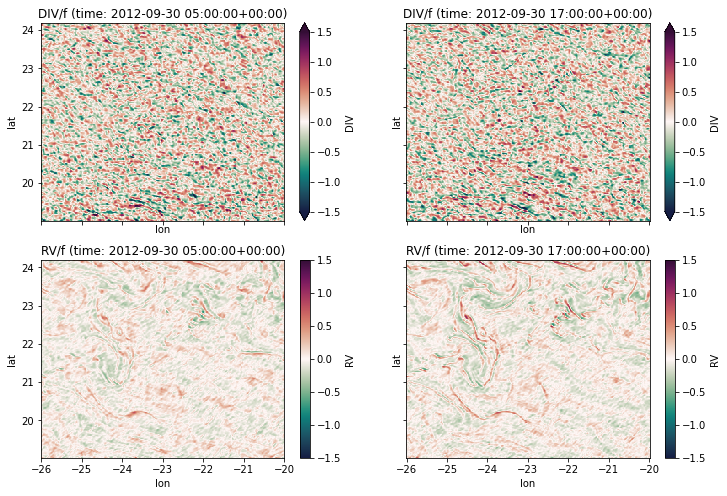

In [185]:
fig_kwargs={'x':'lon', 'y':'lat', 'cmap':'cmo.curl', 'norm':TwoSlopeNorm(vcenter=0.0), 'vmin':-1.5, 'vmax':1.5}

fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharex=True, sharey=True)
t_idx = 24*60+5

_ds1 = ds.isel(t=t_idx)
_t1 = ds_time[t_idx]
_ds1.DIV.plot.pcolormesh(ax=ax[0,0], **fig_kwargs)
ax[0,0].set_title('DIV/f (time: {})'.format(_t1))
_ds1.RV.plot.pcolormesh(ax=ax[1,0], **fig_kwargs)
ax[1,0].set_title('RV/f (time: {})'.format(_t1))

_ds2 = ds.isel(t=t_idx+12)
_t2 = ds_time[t_idx+12]
_ds2.DIV.plot.pcolormesh(ax=ax[0,1], **fig_kwargs)
ax[0,1].set_title('DIV/f (time: {})'.format(_t2))
_ds2.RV.plot.pcolormesh(ax=ax[1,1], **fig_kwargs)
ax[1,1].set_title('RV/f (time: {})'.format(_t2))
fig_rvdiv_map = plt.gcf()

plt.show()

In [186]:
fig_rvdiv_map.savefig('figs/{}/RV-DIV_{}_am-pm_total.pdf'.format(rid, season))

2022-03-07 20:33:33 DEBUG    Assigning font /b'F1' = '/home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2022-03-07 20:34:03 DEBUG    Embedding font /home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2022-03-07 20:34:03 DEBUG    Writing TrueType font.


In [18]:
gc.collect()
client.run(gc.collect)

AttributeError: 'NoneType' object has no attribute 'broadcast'

#### Create filter

In [81]:
filter_mask, kx, ky, om = create_filter_igw10(ds.U.shape, fmax=1.0/12.75, f_coriolis=f_cph, Nbv=Nbv_cph, H=H)
filter_r = filter_mask.compute()


2022-03-23 04:40:57 INFO     f_range -- Nt: 2208, T: 2208.0
2022-03-23 04:40:57 INFO     kxky -- Nx: 289, Ny: 288
2022-03-23 04:40:57 INFO     kxky -- Lx: 578.0, Ly: 576.0
2022-03-23 04:40:57 DEBUG    igw10 shape: (288, 289, 2208)
2022-03-23 04:40:57 DEBUG    cutoff_igw10 shape: (288, 289, 2208)


N=0.979, H=4.902 - mode 10


#### Plot filter

In [82]:
## Only for plot purposes
filter_plot = np.fft.ifftshift(filter_r)
filter_mask_ = filter_plot[144,145:,1104:].squeeze().T

om_r = om.compute()
kx_r = kx.compute()
ky_r = ky.compute()
kx_ = kx_r[144,145:,1104:].squeeze().T
ky_ = ky_r[144,145:,1104:].squeeze().T
om_ = om_r[144,145:,1104:].squeeze().T

print(1/np.min(kx_),1/np.max(kx_))
print(1/np.min(ky_),1/np.max(ky_))
print(1/np.min(om_),1/np.max(om_))
print(np.min(filter_mask_),np.max(filter_mask_))

578.0 4.013888888888888
1152.0 1152.0
4416.0 2.0009062075215223
2.411772939216257e-113 1.0


IndexError: tuple index out of range

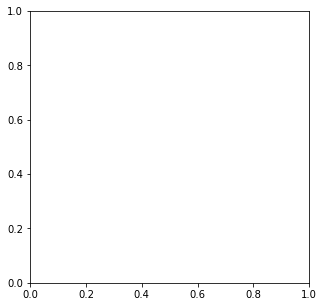

In [117]:
## Display a "cut" of the filter
plt.figure(figsize=(5,5))
plt.pcolormesh(kx_,om_,filter_mask_, cmap=cm.gray)
plt.xscale('log')
plt.xticks(ticks=[1/200., 1/100., 1/50., 1/25., 1/10.], labels=[200, 100, 50, 25, 10], size='large')
plt.xlim([1/250.,1/8.])
plt.yscale('log')
plt.yticks(ticks=[1/7./24.,f_cph, 1/12.0, 1/6., 1/3.], labels=['7d', 'f', '12h', '6h', '3h'], size='large')
plt.ylim([1/(24.*7),1/2.])
plt.xlabel(r'Horizontal wavelength [km]',size='x-large')
plt.ylabel(r'Time scales',size='x-large')
cb = plt.colorbar()
cb.ax.tick_params(labelsize='x-large')
cb.set_label('Filter magnitude [adimentional]')
plt.savefig('figs/{}/wk_filter_2d.pdf'.format(rid))
plt.show()

In [105]:
tidx_min,tidx_max = 1180,1280
print(1/np.abs(f_cph))
print(om_r.shape, 1/om_r[0,0,tidx_min],1/om_r[0,0,tidx_max])
print(np.min(filter_r), np.max(filter_r))

26.761540928923523
(288, 289, 2208) 28.862745098039216 12.509915014164307
2.411772939216257e-113 1.0


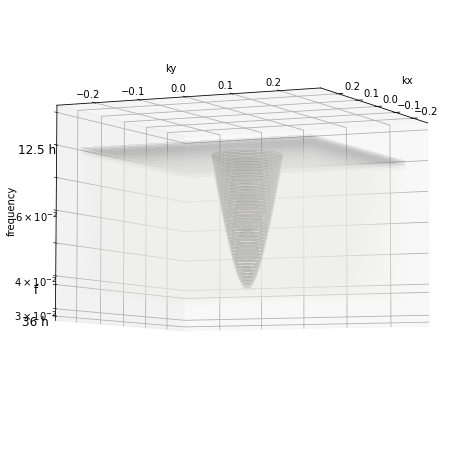

In [116]:
import matplotlib as mpl

om_idx = [i for i in range(om_r.shape[2])]
nlevels=10
lvl = [i/nlevels for i in range(nlevels+1)]
#lvl = [0.4,0.5] 

min_ij=0
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
for i in om_idx[tidx_min:tidx_max]:
    om_ = om_r[0,0,i]
    filter_slice = filter_plot[min_ij:,min_ij:,i].squeeze()
    #print(i,1/om_, np.min(filter_slice), np.max(filter_slice))
    cs = ax.contourf(kx_r[min_ij:,min_ij:,i].squeeze(), ky_r[min_ij:,min_ij:,i].squeeze(), filter_slice, zdir='z', offset=om_, levels=lvl, alpha=0.1, cmap=cm.gray, vcenter=0.1)
ax.set_zscale('log')
ax.set_zlim(1/30., 1/11.)
ax.set_zticks(ticks=[1/36., np.abs(f_cph), 1/12.5], labels=['36 h', 'f', '12.5 h'], size='large')
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('frequency')
ax.view_init(elev=-5, azim=25)
#plt.savefig('figs/{}/wk_filter_3d.pdf'.format(rid))

plt.show()


#### Filter data, save checkpoint 2

In [189]:
U_lo = filter_fft_butterworth_k_omega(ds.U.data, filter_r)
V_lo = filter_fft_butterworth_k_omega(ds.V.data, filter_r)
U_hi = ds.U - U_lo
V_hi = ds.V - V_lo

2022-03-07 20:36:05 INFO     kx-ky-omega BW filter -- variable shape: (290, 289, 2208) -- type: <class 'dask.array.core.Array'>
2022-03-07 20:36:05 INFO     Calculating FFT... mask type: <class 'numpy.ndarray'>
2022-03-07 20:36:05 INFO     Filtering...
2022-03-07 20:36:08 INFO     Calculating inverse FFT and complement
2022-03-07 20:36:08 INFO     Taking real part FFT: <class 'dask.array.core.Array'>
2022-03-07 20:36:08 INFO     kx-ky-omega BW filter -- variable shape: (290, 289, 2208) -- type: <class 'dask.array.core.Array'>
2022-03-07 20:36:08 INFO     Calculating FFT... mask type: <class 'numpy.ndarray'>
2022-03-07 20:36:08 INFO     Filtering...
2022-03-07 20:36:12 INFO     Calculating inverse FFT and complement
2022-03-07 20:36:12 INFO     Taking real part FFT: <class 'dask.array.core.Array'>


In [190]:
ds = xr.Dataset(
    {
        "U_low": (["i", "j", "t"], U_lo),
        "V_low": (["i", "j", "t"], V_lo),
        "U_high":  U_hi, #(["i", "j", "t"], U_hi)
        "V_high": V_hi, #(["i", "j", "t"], V_hi)
    },
    coords={
        "lon": (["i", "j"], XG),
        "lat": (["i", "j"], YG),
        "time": (["t"], ds_time),
    }
)
ds.to_netcdf("{}/datasets/{}_{}2.nc".format(DASK_DATA_FOLDER, rid, season))
del U_lo, V_lo, U_hi, V_hi, filter_r, filter_mask
gc.collect()
client.run(gc.collect)

ds

<xarray.Dataset>
Dimensions:  (i: 290, j: 289, t: 2208)
Coordinates:
    lon      (i, j) float64 -26.0 -25.98 -25.96 -25.94 ... -20.04 -20.02 -20.0
    lat      (i, j) float64 19.03 19.03 19.03 19.03 ... 24.18 24.18 24.18 24.18
    time     (t) int64 1343779200000000000 ... 1351724400000000000
Dimensions without coordinates: i, j, t
Data variables:
    U_low    (i, j, t) float64 dask.array<chunksize=(29, 129, 2208), meta=np.ndarray>
    V_low    (i, j, t) float64 dask.array<chunksize=(29, 129, 2208), meta=np.ndarray>
    U_high   (i, j, t) float64 dask.array<chunksize=(29, 129, 1104), meta=np.ndarray>
    V_high   (i, j, t) float64 dask.array<chunksize=(29, 129, 1104), meta=np.ndarray>

#### Checkpoint 2

In [191]:
ds = xr.open_mfdataset("{}/datasets/{}_{}*.nc".format(DASK_DATA_FOLDER, rid, season), chunks='auto')
ds

<xarray.Dataset>
Dimensions:  (i: 290, j: 289, t: 2208)
Coordinates:
    lon      (i, j) float64 dask.array<chunksize=(290, 289), meta=np.ndarray>
    lat      (i, j) float64 dask.array<chunksize=(290, 289), meta=np.ndarray>
    time     (t) int64 dask.array<chunksize=(2208,), meta=np.ndarray>
Dimensions without coordinates: i, j, t
Data variables:
    RV       (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    DIV      (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    U        (i, j, t) float32 dask.array<chunksize=(145, 207, 1104), meta=np.ndarray>
    V        (i, j, t) float32 dask.array<chunksize=(145, 207, 1104), meta=np.ndarray>
    U_low    (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    V_low    (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    U_high   (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    V_high   (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>

In [192]:
U_lo = ds.U_low #da.moveaxis(ds.U_low.data, -1, 0)
V_lo = ds.V_low #da.moveaxis(ds.V_low.data, -1, 0)
U_hi = ds.U_high #da.moveaxis(ds.U_high.data, -1, 0)
V_hi = ds.V_high #da.moveaxis(ds.V_high.data, -1, 0)

RV_lo = grid.rv(U_lo, V_lo)*f_rps_inv
DIV_lo = grid.div(U_lo, V_lo)*f_rps_inv
RV_hi = grid.rv(U_hi, V_hi)*f_rps_inv
DIV_hi = grid.div(U_hi, V_hi)*f_rps_inv

#### Calculate RV/DIV on filtered data, save checkpoint 3

In [193]:
ds = xr.Dataset(
    {
        "RVlo": (["i", "j", "t"], RV_lo),
        "RVhi": (["i", "j", "t"], RV_hi),
        "DIVlo": (["i", "j", "t"], DIV_lo),
        "DIVhi": (["i", "j", "t"], DIV_hi),
    },
    coords={
        "lon": (["i", "j"], XG),
        "lat": (["i", "j"], YG),
        "time": (["t"], ds_time),
    }
)
ds.to_netcdf("{}/datasets/{}_{}3.nc".format(DASK_DATA_FOLDER, rid, season))
del RV_lo, DIV_lo, RV_hi, DIV_hi, U_lo, V_lo, U_hi, V_hi
gc.collect()
client.run(gc.collect)

ds

<xarray.Dataset>
Dimensions:  (i: 290, j: 289, t: 2208)
Coordinates:
    lon      (i, j) float64 -26.0 -25.98 -25.96 -25.94 ... -20.04 -20.02 -20.0
    lat      (i, j) float64 19.03 19.03 19.03 19.03 ... 24.18 24.18 24.18 24.18
    time     (t) object 1343779200000000000 ... 1351724400000000000
Dimensions without coordinates: i, j, t
Data variables:
    RVlo     (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    RVhi     (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    DIVlo    (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    DIVhi    (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>

#### Load all checkpoints and plot filtered vs unfiltered, calculate RMS timeseries

In [194]:
ds = xr.open_mfdataset("{}/datasets/{}_{}*.nc".format(DASK_DATA_FOLDER, rid, season), chunks='auto')

#_tvec = list(map(lambda x: simulationTime(int(x)),ds.time.values))
_tvec = pd.to_datetime(ds.time.values, unit='ns')
#ds["time"] = (["t"], _tvec)
#ds

#_tvec = ds.time.values

ds

<xarray.Dataset>
Dimensions:  (i: 290, j: 289, t: 2208)
Coordinates:
    lon      (i, j) float64 dask.array<chunksize=(290, 289), meta=np.ndarray>
    lat      (i, j) float64 dask.array<chunksize=(290, 289), meta=np.ndarray>
    time     (t) int64 dask.array<chunksize=(2208,), meta=np.ndarray>
Dimensions without coordinates: i, j, t
Data variables:
    RV       (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    DIV      (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    RVlo     (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    RVhi     (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    DIVlo    (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    DIVhi    (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    U        (i, j, t) float32 dask.array<chunksize=(145, 207, 1104), meta=np.ndarray>
    V        (i, j, t) float32 dask.array<chunksize=(145, 207, 1104), meta=np.ndarray>
    U_low    (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    V_low    (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    U_high   (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>
    V_high   (i, j, t) float64 dask.array<chunksize=(145, 155, 736), meta=np.ndarray>

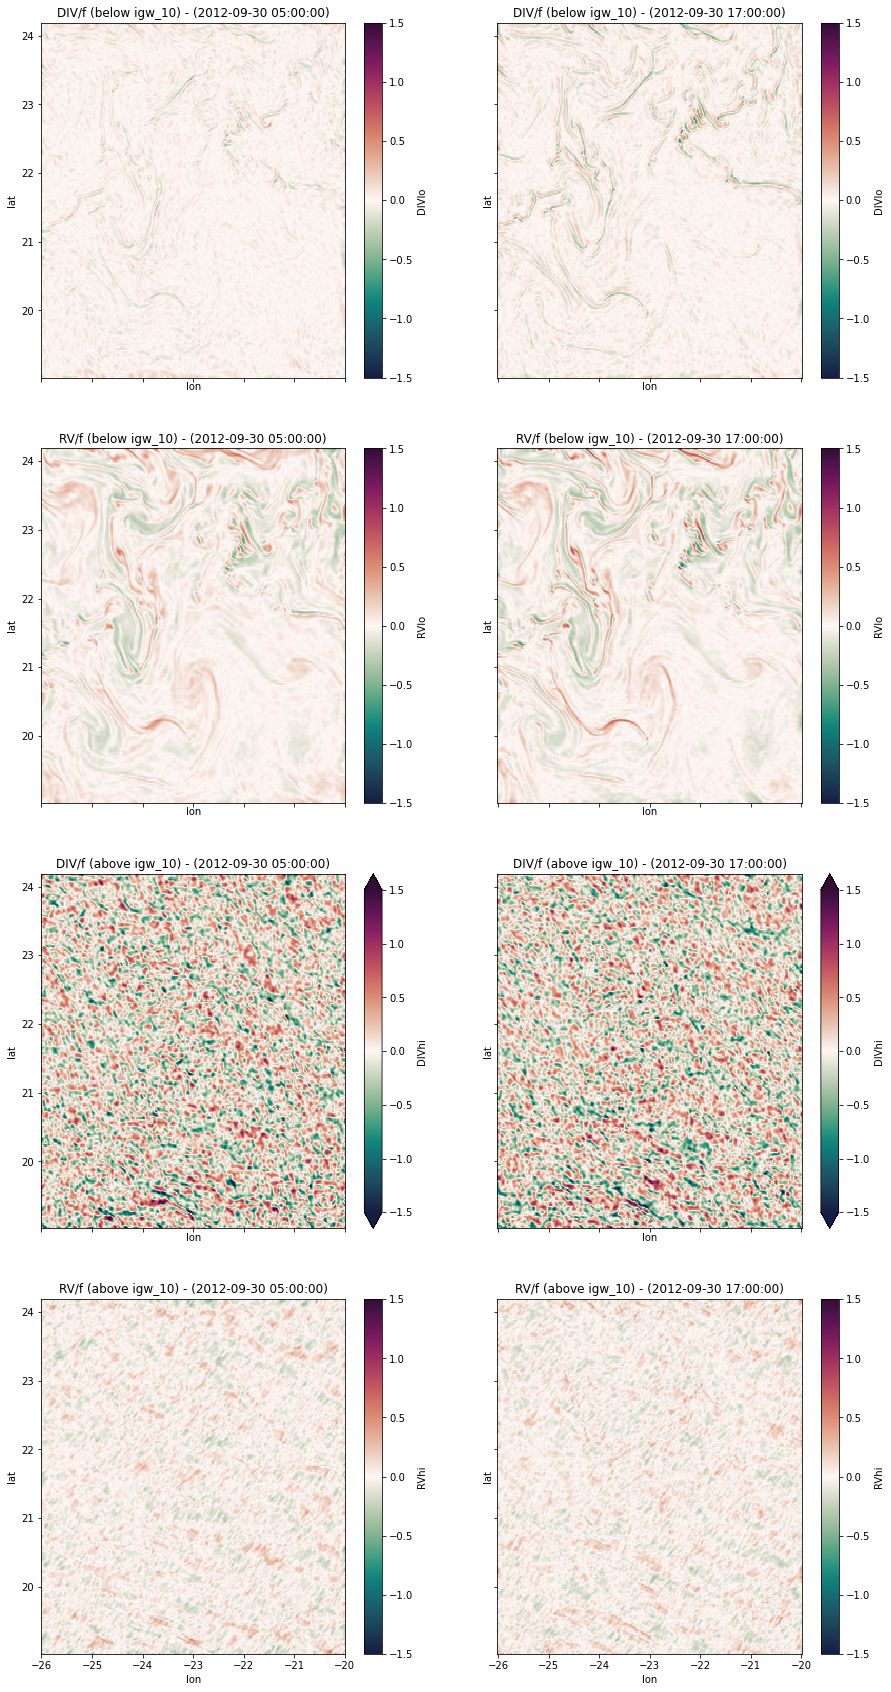

In [195]:
fig_kwargs={'x':'lon', 'y':'lat', 'cmap':'cmo.curl', 'norm':TwoSlopeNorm(vcenter=0.0), 'vmin':-1.5, 'vmax':1.5}

fig,ax = plt.subplots(nrows=4, ncols=2, figsize=(15,30), sharex=True, sharey=True)
t_idx = 24*60+5

_ds1 = ds.isel(t=t_idx)
_t1 = _tvec[t_idx]
_ds1.DIVlo.plot.pcolormesh(ax=ax[0,0], **fig_kwargs)
ax[0,0].set_title('DIV/f (below igw_10) - ({})'.format(_t1))
_ds1.RVlo.plot.pcolormesh(ax=ax[1,0], **fig_kwargs)
ax[1,0].set_title('RV/f (below igw_10) - ({})'.format(_t1))
_ds1.DIVhi.plot.pcolormesh(ax=ax[2,0], **fig_kwargs)
ax[2,0].set_title('DIV/f (above igw_10) - ({})'.format(_t1))
_ds1.RVhi.plot.pcolormesh(ax=ax[3,0], **fig_kwargs)
ax[3,0].set_title('RV/f (above igw_10) - ({})'.format(_t1))

_ds2 = ds.isel(t=t_idx+12)
_t2 = _tvec[t_idx+12]
_ds2.DIVlo.plot.pcolormesh(ax=ax[0,1], **fig_kwargs)
ax[0,1].set_title('DIV/f (below igw_10) - ({})'.format(_t2))
_ds2.RVlo.plot.pcolormesh(ax=ax[1,1], **fig_kwargs)
ax[1,1].set_title('RV/f (below igw_10) - ({})'.format(_t2))
_ds2.DIVhi.plot.pcolormesh(ax=ax[2,1], **fig_kwargs)
ax[2,1].set_title('DIV/f (above igw_10) - ({})'.format(_t2))
_ds2.RVhi.plot.pcolormesh(ax=ax[3,1], **fig_kwargs)
ax[3,1].set_title('RV/f (above igw_10) - ({})'.format(_t2))

fig_rvdiv_filtered_map = plt.gcf()

plt.show()

In [196]:
fig_rvdiv_filtered_map.savefig('figs/{}/RV-DIV_{}_am-pm.pdf'.format(rid, season))
#MALLOC_TRIM_THRESHOLD_

2022-03-07 20:41:01 DEBUG    Assigning font /b'F1' = '/home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2022-03-07 20:42:05 DEBUG    Embedding font /home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2022-03-07 20:42:05 DEBUG    Writing TrueType font.


#### Checkpoint 4: stats

In [197]:
ds = xr.Dataset(
    {
        "RV_rms": ds.RV.std(dim=("i","j")),
        "DIV_rms": ds.DIV.std(dim=("i","j")),
        "RVlo_rms": ds.RVlo.std(dim=("i","j")),
        "DIVlo_rms": ds.DIVlo.std(dim=("i","j")),
        "RVhi_rms": ds.RVhi.std(dim=("i","j")),
        "DIVhi_rms": ds.DIVhi.std(dim=("i","j"))
    },
    coords={
        "time": (["t"], ds_time),
    }
)
ds.to_netcdf("{}/datasets/{}_{}4.nc".format(DASK_DATA_FOLDER, rid, season))

ds

<xarray.Dataset>
Dimensions:    (t: 2208)
Coordinates:
    time       (t) int64 1343779200000000000 ... 1351724400000000000
Dimensions without coordinates: t
Data variables:
    RV_rms     (t) float64 dask.array<chunksize=(736,), meta=np.ndarray>
    DIV_rms    (t) float64 dask.array<chunksize=(736,), meta=np.ndarray>
    RVlo_rms   (t) float64 dask.array<chunksize=(736,), meta=np.ndarray>
    DIVlo_rms  (t) float64 dask.array<chunksize=(736,), meta=np.ndarray>
    RVhi_rms   (t) float64 dask.array<chunksize=(736,), meta=np.ndarray>
    DIVhi_rms  (t) float64 dask.array<chunksize=(736,), meta=np.ndarray>

### Load all checkpoints

In [204]:
ds = xr.open_mfdataset("{}/datasets/{}_{}*.nc".format(DASK_DATA_FOLDER, rid, season), chunks='auto')

#_tvec = list(map(lambda x: simulationTime(int(x)),ds.time.values))
_tvec = pd.to_datetime(ds.time.values, unit='ns')
ds["time"] = (["t"], _tvec)
#ds

#_tvec = ds.time.values

ds

<xarray.Dataset>
Dimensions:   (i: 288, j: 289, t: 2208)
Coordinates:
    lon       (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    lat       (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    time      (t) datetime64[ns] 2012-08-01 ... 2012-10-31T23:00:00
Dimensions without coordinates: i, j, t
Data variables:
    Theta     (i, j, t) float32 dask.array<chunksize=(144, 209, 1104), meta=np.ndarray>
    oceQnet   (i, j, t) float32 dask.array<chunksize=(144, 209, 1104), meta=np.ndarray>
    tau_x     (i, j, t) float32 dask.array<chunksize=(144, 209, 1104), meta=np.ndarray>
    tau_y     (i, j, t) float32 dask.array<chunksize=(144, 209, 1104), meta=np.ndarray>
    tau_norm  (i, j, t) float32 dask.array<chunksize=(144, 209, 1104), meta=np.ndarray>
    KPPhbl    (i, j, t) float32 dask.array<chunksize=(144, 209, 1104), meta=np.ndarray>
    U         (i, j, t) float32 dask.array<chunksize=(144, 209, 1104), meta=np.ndarray>
    V         (i, j, t) float32 dask.array<chunksize=(144, 209, 1104), meta=np.ndarray>

### Plots: STDEV

In [199]:
ts_fig_kwargs={'x':'time', 'y':'lat', 'cmap':'cmo.curl', 'norm':TwoSlopeNorm(vcenter=0.0), 'vmin':-1.5, 'vmax':1.5}
trange_7days = slice(24*40,24*48)

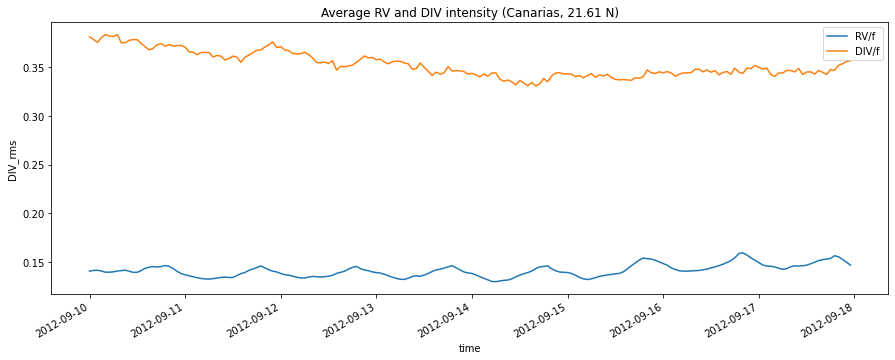

In [200]:
plt.figure(figsize=(15,5))
ds.RV_rms.isel(t=trange_7days).plot(label="RV/f", x="time")
ds.DIV_rms.isel(t=trange_7days).plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N)".format(current,lat_deg))
fig_stv7d_total = plt.gcf()
plt.show()

In [201]:
fig_stv7d_total.savefig('figs/{}/RV-DIV_{}_stdev_7days.png'.format(rid, season))

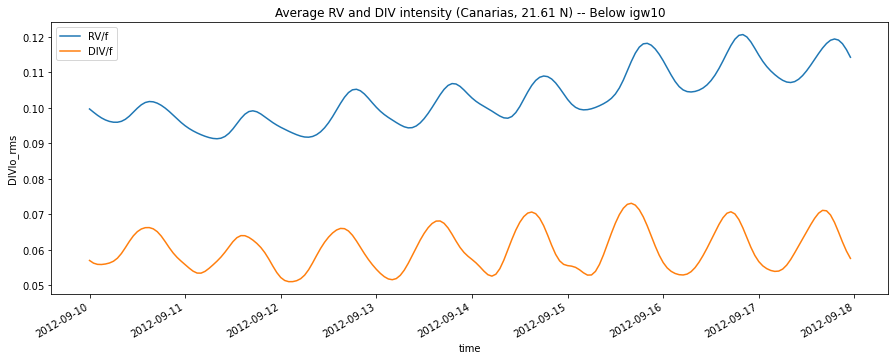

In [202]:
plt.figure(figsize=(15,5))
ds.RVlo_rms.isel(t=trange_7days).plot(label="RV/f", x="time")
ds.DIVlo_rms.isel(t=trange_7days).plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Below igw10".format(current,lat_deg))
fig_stv7d_bm = plt.gcf()
plt.show()

In [203]:
fig_stv7d_bm.savefig('figs/{}/RV-DIV_{}_stdev_bm_7days.png'.format(rid, season))

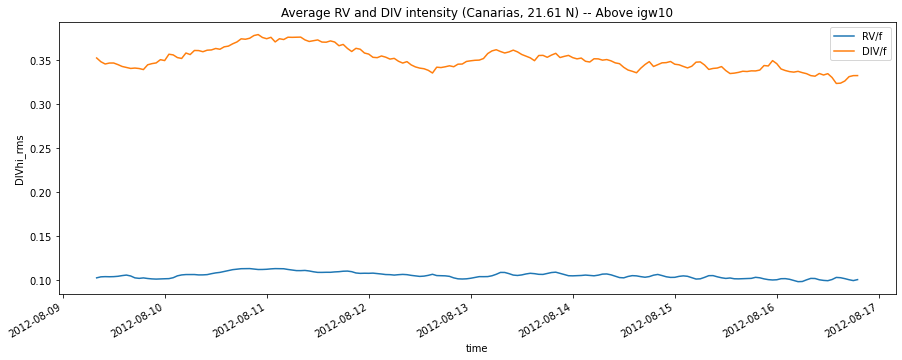

In [204]:
plt.figure(figsize=(15,5))
ds.RVhi_rms.isel(t=slice(200,380)).plot(label="RV/f", x="time")
ds.DIVhi_rms.isel(t=slice(200,380)).plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Above igw10".format(current,lat_deg))
fig_stv7d_igw = plt.gcf()
plt.show()

In [205]:
fig_stv7d_igw.savefig('figs/{}/RV-DIV_{}_stdev_igw_7days.png'.format(rid, season))

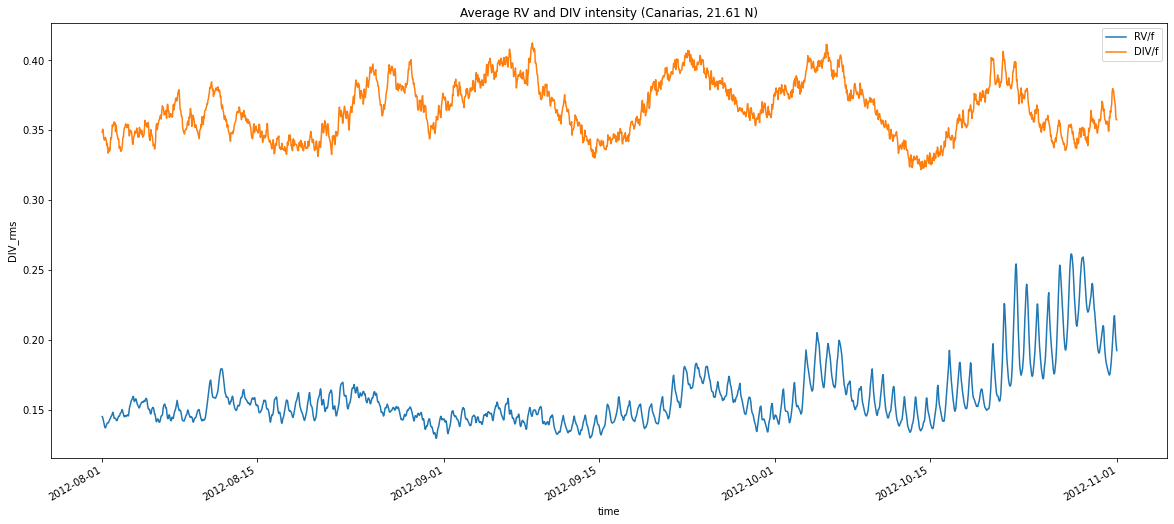

In [206]:
plt.figure(figsize=(20,8))
ds.RV_rms.plot(label="RV/f", x="time")
ds.DIV_rms.plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N)".format(current, lat_deg))
fig_std_season = plt.gcf()
plt.show()

In [207]:
fig_std_season.savefig('figs/{}/RV-DIV_{}_stdev.png'.format(rid,season))

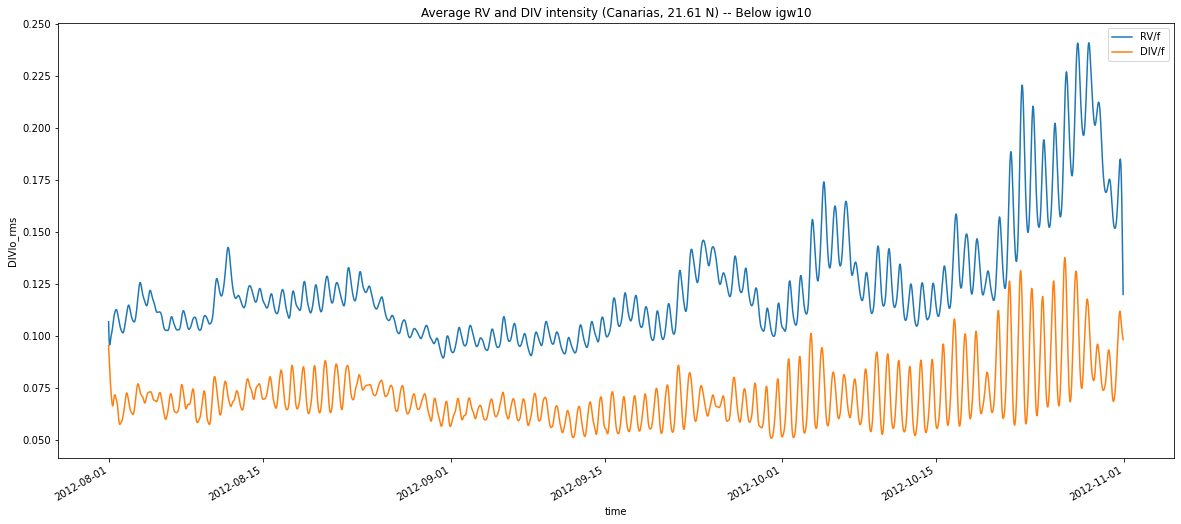

In [208]:
plt.figure(figsize=(20,8))
ds.RVlo_rms.plot(label="RV/f", x="time")
ds.DIVlo_rms.plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Below igw10".format(current, lat_deg))
fig_std_bm_season = plt.gcf()
plt.show()

In [209]:
fig_std_bm_season.savefig('figs/{}/RV-DIV_{}_stdev_bm.png'.format(rid,season))

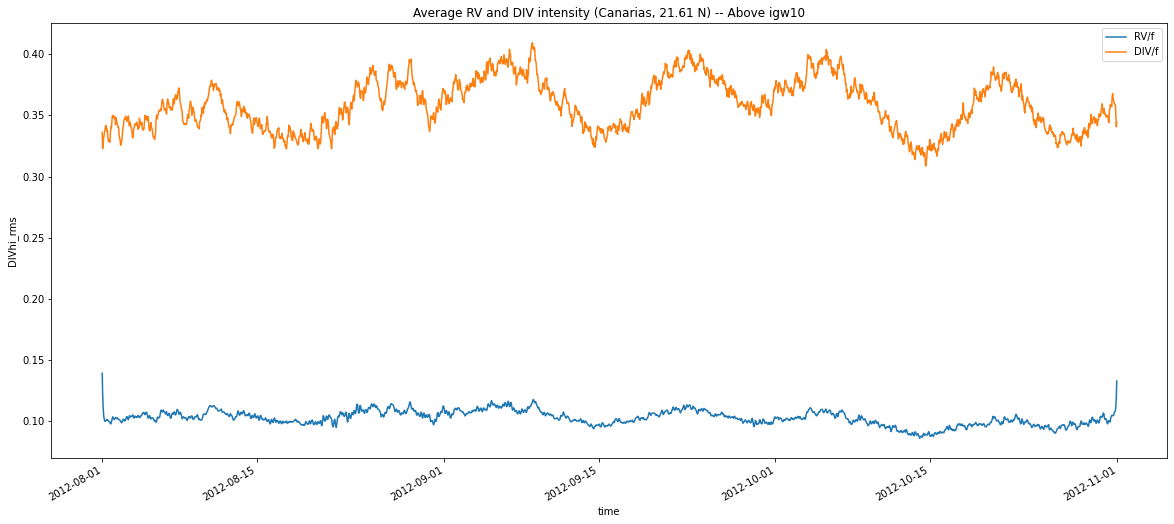

In [210]:
plt.figure(figsize=(20,8))
ds.RVhi_rms.plot(label="RV/f", x="time")
ds.DIVhi_rms.plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Above igw10".format(current, lat_deg))
fig_std_igw_season = plt.gcf()
plt.show()

In [211]:
fig_std_igw_season.savefig('figs/{}/RV-DIV_{}_stdev_igw.png'.format(rid,season))

## Figures: time series